In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


## Lab 2: Image Stitching with Homographies

In this lab, we will explore image stitching and panorama creation. You will use a homography to register two images together, and implement bilinear interpolation to help accomplish this. As part of the lab, you will also explore image enhancement strategies to improve the quality of image stitching at the seam (the join between two images) relying on your knowledge of image brightness and human perception of this. Collectively, tasks 1-5 will provide a final stitched image. In task 6, you will apply the same code written in tasks 1-5 to create a panorama image using your own photos.

* Task 1: Draw test points on the left image
* Task 2: Use a homography to find the location of these points in the right image
* Task 3: Bilinear interpolation of the right image pixels
* Task 4: Image stitching 
* Task 5: Better blending
* Task 6: Now try your own!

### Academic integrity

Every lab submission will be screened for any collusion and/or plagiarism. Breaches of academic integrity will be investigated thoroughly and may result in a zero for the assessment along with interviews with the plagiarism officers at Monash University.

### Late submissions

The default late submission university penalty will apply.

### Lab Instructions and the Use of Generative AI

You may not use any built-in opencv functions for this lab, other than those used for loading/ saving an image, extracting and matching keypoints, and
computing homographies.
* You may use NumPy for array handling, and vectorizing your code (reducing
the number of for-loops) is encouraged.
* You should use Matplotlib to display images and any intermediate results.
* You may use generative AI.

### Grading
Each lab is worth 8%, and there are a number of sections and tasks with their own weighting. A task is only considered complete if you can demonstrate a working program and show an understanding of the underlying concepts. Note that later tasks should reuse code from earlier tasks.

Masks will be provided based on the correctness of the code, the quality of your results, comments indicating you understand your work, and a discussion of tasks provided at the end of the notebook. 

# Task 1: Draw test points on the left image

Draw the following points on the left image as red crosses. Display the resulting image.

{446 , 499, 1}, {383, 590, 1}, {296 , 499, 1}, {282, 511, 1}, {401 , 508, 1}

Recall from lectures that these 3-element homogeneous coordinates can be transformed to 2D image pixel coordinates by dividing the first and second elements by the third (needed for later tasks).

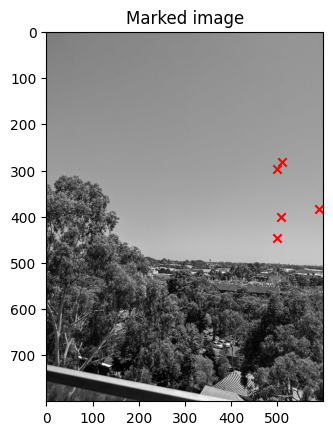

In [ ]:
# Write your code here

#Image importing
im_left = cv2.imread('left.jpg')
im_right = cv2.imread('right.jpg')
#Plot points on the left image:
plt.figure(1)
plt.imshow(im_left)
# Our array of points:
pts = np.array([[446, 499, 1], [383, 590, 1], [296, 499, 1], [282, 511, 1], [401, 508, 1]])
# Draw points on the image
plt.scatter(pts[:, 1], pts[:, 0], marker='x', color='r') # x = cols, y = rows
plt.title("Marked image")
plt.show()




# Task 2: Use Homography to find right image points


The following homography transforms pixel coordinates between the left and right images as
$$ x_R = H x_L $$

\begin{bmatrix}
1.6011 & 0.0277 & -393.5701 \\
0.3242 & 1.5119 & -228.8918 \\
0.0009 & 0.0002 & 1.0000
\end{bmatrix}

Apply the homography to transform the left image points in Task 1 to their corresponding locations in the right image. Draw the transformed points as red crosses on the right image. Check your result before moving on.


In [20]:
# Write your code here
# Define our homography matrix H:
H = np.array([[1.6011, 0.0277, -393.5701], [0.3242, 1.5119, -228.8918], [0.0009, 0.0002, 1.0000]])

# Transpose
pts_homogeneous = pts.T

# Apply the homography matrix to each point
xR = []
for col in range(pts_homogeneous.shape[1]):
    transformed_point = H @ pts_homogeneous[:, col]
    #convert to 2D by dividing by the third coordinate
    transformed_point /= transformed_point[2]
    xR.append(transformed_point[:2])  

# Convert xR to np arr
xR = np.array(xR)
print(im_right[0,0, 0])


116


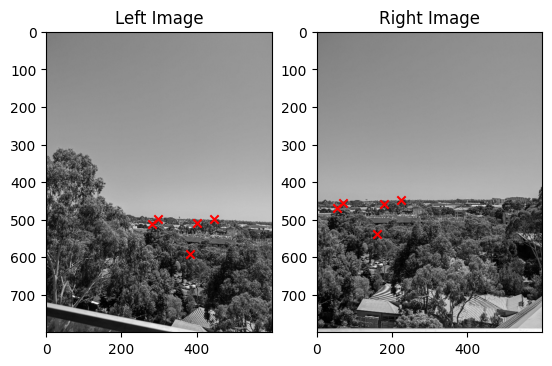

In [21]:
# Print results here
plt.figure(2)
plt.subplot(1,2,1)
plt.imshow(im_left)
plt.scatter(pts[:, 0], pts[:, 1], marker='x', color='r')
plt.title("Left Image")
plt.subplot(1,2,2)
plt.imshow(im_right)
plt.scatter(xR[:, 0], xR[:, 1], marker='x', color='r')
plt.title("Right Image")
plt.show()

# Task 3: Bilinear interpolation of the right image

The transformed coordinates can be in between pixel locations. Write a bilinear interpolation function to compute the intensity of the transformed pixel coordinate in right.jpg using intensity values from neighbouring pixel locations. Print the interpolated intensity value for each transformed point in Task 2. The first point should be around 176 whereas the last point should be around 73.

HINT: The bilinear interpolation function should take the transformed pixel coordinate and the intensity values of its four neighbours as input arguments, and should output the interpolated intensity value.

In [16]:
# Write your code here
# We can save the effort of getting neigbours by creating a function
def get_neighbours(image,  point: list):
    x = point[1]
    y = point[0]
    x1, y1 = int(np.floor(x)), int(np.ceil(y)) # y=0 is at the top of the image
    x2, y2 = int(np.ceil(x)), int(np.floor(y))
    # Check if the pixel is in the image bounds
    if x1 < 0 or y1 < 0 or x2 >= image.shape[1]-1 or y2 >= image.shape[0]-1:
        #Ignore the pixel if it is out of bounds
        return [0, 0, 0, 0]
    return [image[y1, x1, 0], image[y1, x2, 0], image[y2, x1, 0], image[y2, x2, 0]]


def bilinear_interp(pixel: list,  neighbours: list[int]) -> float: 
    """interpolated pixel = bilinear_interp(pixel[x, y], neighbours[1, 2, 3, 4])
    pixel: coordinates of the pixel to be interpolated
    neighbours: Top left, Top right, Bottom left, Bottom right"""
    # Raise an error if there are more than 4 neighbours
    if len(neighbours) != 4:
        raise ValueError("--4 neighbouring pixel values are required--")
    
    tl = neighbours[0]
    tr = neighbours[1]
    bl = neighbours[2]
    br = neighbours[3]
    
    x = pixel[1]
    y = pixel[0]
    # Manage division by zero in x2-x1 and y2-y1
    
    x1, y1 = int(np.floor(x)), int(np.ceil(y))
    x2, y2 = int(np.ceil(x)), int(np.floor(y))
    dx = x2-x1 if x2-x1 != 0 else 1
    dy = y2-y1 if y2-y1 != 0 else 1
    xy1 = ((x2-x)/(dx))*bl+((x-x1)/(dx))*br
    xy2 = ((x2-x)/(dx))*tl+((x-x1)/(dx))*tr
    interpolated = ((y2-y)/(dy))*xy1 + ((y-y1)/(dy))*xy2
    
    return interpolated
    


In [17]:
# Show results here
interp = np.zeros((len(xR)))
for point in range(len(xR)):
    # Neighbour func
    neighbours = get_neighbours(im_right, xR[point])
    interp[point] = bilinear_interp(xR[point], neighbours)
    print(f" Point {point+1}: {interp[point]}")


 Point 1: 154.0
 Point 2: 153.24441976578458
 Point 3: 146.0
 Point 4: 145.83274336283188
 Point 5: 152.0


# Task 4: Image stitching

Create a 1200x800 (width x height) image and fill the left hand side of this image with the left image. This stitched image will use the left image coordinate system (xl) throughout the stitching process. Next, fill in the remaining pixels on the RHS by transforming their pixel coordinates (left image coordinates) to the right image coordinates via the homography from Task 2 and determining the intensity using your bilinear interpolation implementation. If the right pixel  coordinate is valid, generate the pixel value using bilinear interpolation, but if the right pixel coordinate is invalid, use a pixel value of zero. Display the stitching results. It should look like a wide-angle image with a visible seam where the two images join.

In [ ]:
# Write your code here
# create a new image
im_stitched = np.zeros((im_left.shape[0], 1200, 1), dtype=np.uint8)

#Transpose the homography matrix
H = np.transpose(H)

for row in range(im_stitched.shape[0]):
    for col in range(im_stitched.shape[1]):
        #If the pixel is from the left image range, insert it straight in
        if col <= im_left.shape[1]:
            im_stitched[row, col, :]= im_left[row, col, :]




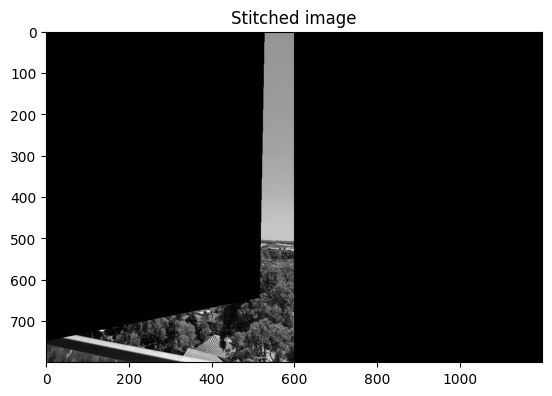

In [15]:
# Show results here
plt.imshow(im_stitched, cmap='gray')
plt.title("Stitched image")
plt.show()

# Task 5: Better blending

Improve the visual quality of the stitched image by trying the following image processing techniques:

1. Adjust the width of the output image automatically so that fewer black pixels are
visible 
2. Adjust the brightness (by a scaling factor) of each image so that the seam is less
visible
3. Apply a small amount of Gaussian blur or alpha blending near the seam to make
it less visible
4. Adjust the horizontal location of the seam (it can be moved further to the left as
the right image overlaps into the left by quite a few pixels)

Note that you do not have to try all of the above. However, you will only receive a mark here depending on
• the quality of the stitched image
• whether a serious programming attempt is made to improve the visual quality of the stitched image

In [10]:
# Write your code here

In [11]:
# Show results here





# Task 6: Now try your own!

In this final task, you will:
1. Take two images from different perspective of the same scenery and display it
2. Find and match key points across the two images
3. Calculate the homography matrix1 . Print out the homography matrix that you end
up using.
4. Apply image stitching and quality improvement for a final image (from tasks 1 to 5)

In [12]:
# Write your code here

In [13]:
# Show results here





# Discussion:

Write a brief (600 word max) report describing how you solved each task, interpreting the results and pointing to any insights gained along the way. For example, you may wish to explain what a homography is, the conditions under which it can be used. Analyse the stitched images and explain any interesting artifacts you may see and why these occur. You should discuss the reasons for the presence of the image seam, and the strategies you used to improve this, pointing to the theory you have learned in class that guided your solution. Finally, explain any changes you made to the code to apply it to your own images. 

